## Introduction

For this project, we set out to answer the question: **What is the best neighborhood in Pittsburgh?** 

After exploring various datasets available through the WPRDC (Western Pennsylvania Regional Data Center), we decided to focus on the overarching theme of **safety** as our primary metric for determining the "best" neighborhood. We believe that safety is a fundamental requirement for any neighborhood to be considered truly "best" - no matter how vibrant or culturally rich an area might be, if residents don't feel safe, it cannot be the best place to live.

### Our Approach

We considered several alternative approaches to measuring "bestness":
- **Economic factors**: Income levels, property values, employment rates
- **Quality of life**: Parks, restaurants, walkability, cultural amenities
- **Education**: School quality, libraries, educational resources
- **Safety**: Crime rates, fire incidents, environmental hazards

Ultimately, we chose to focus on safety because it is foundational; you cannot fully enjoy other neighborhood amenities if you're concerned about your personal safety, property security, or environmental health.

### The Three Datasets

We selected three complementary datasets that together provide a comprehensive view of neighborhood safety:

1. **Monthly Crime Statistics in Pittsburgh** - Measures personal safety and security
2. **Toxic Air Releases** - Measures environmental health and air quality  
3. **Fire Incidents** - Measures infrastructure safety and emergency preparedness



Crime is one of the most important factors when it comes to picking a safe neighborhood. With the dataset, we were able to see which neighborhoods have had the most counts of crime from January 1st, 2024, to October 1st, 2025, and which neighborhoods had the least crime. We also accounted for the weight of different crimes, by looking at the neighborhood's crime count on just more serious convictions, like assault, and robbery. Air quality is another part of having a safe neighborhood, because people won’t want to stay in a place with toxic air pollution. It shows that the city isn’t in a place to sustain a positive living space and good health, and leads to an unsafe neighborhood. Lastly, a city with high fire incidents, puts residents, houses, and buildings in danger, which can lead to injuries, and deaths. It also shows a lack in the police force and the fire department, which is a hallmark of an unsafe neighborhood, and also could mean that buildings and houses aren't up to the standard that they should be.

## Metrics

Our group focused on three key metrics to evaluate which neighborhood in Pittsburgh could be considered the “best.” Connor's metric analyzed fire incidents, representing community safety and emergency preparedness. Fewer fire reports suggest safer environments and better infrastructure. Akansh’s metric examined crime data, which captures the general safety and security of each neighborhood; lower crime rates indicate more stable and livable communities. Riya’s metric measured air toxicity levels, reflecting environmental quality and public health conditions across different areas. Together, these three metrics provide a well-rounded picture of neighborhood quality. While toxic air highlights environmental health, crime and fire incidents emphasize individual safety. By combining these perspectives, our project identifies neighborhoods that are not only safe from crime and emergencies but also offer clean air and healthier living conditions, providing a balanced, data-driven view of what makes a neighborhood the “best” in Pittsburgh.

## The Best Neighborhood: East Carnegie

After analyzing data from three comprehensive safety datasets, **East Carnegie** emerges as the best neighborhood in Pittsburgh based on our combined safety metric.

### The Analysis Methodology

We combined rankings from three independent analyses to create a holistic view of neighborhood safety:

1. **Air Toxicity Analysis**: Ranked neighborhoods by total toxic air releases (in pounds) from 2015-2024. Lower releases indicate cleaner, healthier air and better environmental conditions for residents.

2. **Fire Incidents Analysis**: Ranked neighborhoods by the number of reported fire incidents. Fewer incidents indicate safer infrastructure, better building maintenance, and more effective emergency response systems.

3. **Crime Rate Analysis**: Ranked neighborhoods by serious crime counts (including assaults, thefts, burglaries, and violent crimes). Lower crime rates indicate safer streets and more secure communities.

### How We Combined the Metrics

Each neighborhood received a rank (1 = best, higher numbers = worse) for each of the three metrics. We then calculated a **combined score** by summing all three ranks. This approach ensures that neighborhoods must perform well across all safety dimensions to rank highly.

**The neighborhood with the lowest combined score is identified as the overall best.**

This methodology rewards balanced safety across all dimensions rather than extreme performance in just one area.

## Data Processing and Analysis

Below, we process and combine data from all three datasets to create our final ranking. Each dataset is loaded, cleaned, and ranked independently before being merged into a combined score.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 1. Processing Air Toxicity Rankings
# Dataset: Toxic Air Releases from EPA (2015-2024)
# Source: WPRDC - Allegheny County Toxics Release Inventory (TRI Air)
# Dataset: https://data.wprdc.org/dataset/toxic-release-inventory
# Resource: TRI Air - https://data.wprdc.org/datastore/dump/2750b8c8-246b-430f-b1e0-1aa96e00b013
# Contains toxic air releases reported to EPA by facility, ZIP code, and year
# We filter for recent data (2015-2024) to focus on current conditions

import fpsnippets

toxic_air_url = "https://data.wprdc.org/datastore/dump/2750b8c8-246b-430f-b1e0-1aa96e00b013"
toxic_air_df = pd.read_csv(toxic_air_url)


recent_data = toxic_air_df[toxic_air_df['REPORTING_YEAR'] >= 2015].copy()

# Convert zip codes to neighborhoods
zip_neighborhood_map = {}
unique_zips = recent_data['ZIP_CODE'].dropna().unique()

for zip_code in unique_zips:
    try:
        zip_int = int(float(str(zip_code).split('.')[0]))
        neighborhoods = fpsnippets.zip_to_neighborhoods(zip_int)
        if neighborhoods:
            zip_neighborhood_map[zip_code] = neighborhoods
    except (ValueError, TypeError):
        continue

# Map releases to neighborhoods
neighborhood_releases = []
for idx, row in recent_data.iterrows():
    zip_code = row['ZIP_CODE']
    if pd.notna(zip_code) and zip_code in zip_neighborhood_map:
        neighborhoods = zip_neighborhood_map[zip_code]
        total_release = row['TOTAL_RELEASE']
        if pd.notna(total_release):
            try:
                release_value = float(total_release)
                release_per_neighborhood = release_value / len(neighborhoods) if neighborhoods else 0
                for neighborhood in neighborhoods:
                    neighborhood_releases.append({
                        'neighborhood': neighborhood,
                        'total_release': release_per_neighborhood
                    })
            except (ValueError, TypeError):
                continue

air_toxicity = pd.DataFrame(neighborhood_releases).groupby('neighborhood')['total_release'].sum().reset_index()
air_toxicity.columns = ['neighborhood', 'toxic_release']
air_toxicity = air_toxicity.sort_values(by='toxic_release', ascending=True)


/Users/riyashah/miniconda3/lib/python3.12/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/riyashah/miniconda3/lib/python3.12/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/riyashah/miniconda3/lib/python3.12/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/riyashah/miniconda3/lib/python3.12/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/riyashah/miniconda3/lib/python3.12/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/riyashah/miniconda3/lib/python3.12/site-packages/shapely/predicates.py:878: RuntimeWarning: invali

In [14]:
# 2. Processing Fire Incidents
# Dataset: Fire Incidents in City of Pittsburgh
# Source: https://data.wprdc.org/dataset/fire-incidents-in-city-of-pittsburgh
# Contains all reported fire incidents with neighborhood information
# We count incidents per neighborhood - fewer incidents = safer neighborhood

url = "https://data.wprdc.org/datastore/dump/8d76ac6b-5ae8-4428-82a4-043130d17b02"
fire_df = pd.read_csv(url)
fire_incidents = fire_df['neighborhood'].value_counts().reset_index()
fire_incidents.columns = ['neighborhood', 'fire_count']
fire_incidents = fire_incidents.sort_values(by='fire_count', ascending=True)

In [15]:
# 3. Loading Crime Rankings from Akansh's Notebook
# Dataset: Monthly Crime Statistics (January 2024 - October 2025)
# WPRDC Dataset: https://data.wprdc.org/dataset/monthly-criminal-activity-dashboard
# Focusing on serious crimes: Assault, Robbery, Burglary, Theft, Violent Crimes
# Lower crime counts = safer neighborhood

crime_counts_data = {
    'Ridgemont': 4, 'New Homestead': 8, 'Saint Clair': 9, 'Regent Square': 14,
    'Swisshelm Park': 15, 'Hays': 15, 'Chartiers': 17, 'East Carnegie': 18,
    'Summer Hill': 22, 'Esplen': 24, 'Allegheny West': 25, 'Oakwood': 27,
    'Mount Oliver': 29, 'Bon Air': 34, 'Arlington Heights': 34, 'Windgap': 35,
    'Fairywood': 39, 'Southshore': 39, 'Spring Garden': 41, 'Polish Hill': 44,
    'Duquesne Heights': 44, 'Glen Hazel': 45, 'West End': 55, 'Morningside': 62,
    'Friendship': 62
}

crime_counts = pd.DataFrame(list(crime_counts_data.items()), 
                           columns=['neighborhood', 'crime_count'])
crime_counts = crime_counts.sort_values(by='crime_count', ascending=True)

In [ ]:
# Combine all three datasets into a unified ranking
# Step 1: Assign ranks (1 = best, higher = worse) for each metric
air_toxicity['air_rank'] = range(1, len(air_toxicity) + 1)
fire_incidents['fire_rank'] = range(1, len(fire_incidents) + 1)
crime_counts['crime_rank'] = range(1, len(crime_counts) + 1)

# Step 2: Merge all three datasets (outer join to include all neighborhoods)
combined = pd.merge(air_toxicity[['neighborhood', 'air_rank', 'toxic_release']], 
                    fire_incidents[['neighborhood', 'fire_rank', 'fire_count']], 
                    on='neighborhood', how='outer')

combined = pd.merge(combined, 
                    crime_counts[['neighborhood', 'crime_rank', 'crime_count']], 
                    on='neighborhood', how='outer')

# Step 3: Handle missing values - neighborhoods not in a dataset get worst rank
# This ensures neighborhoods are penalized if they lack data in any category
max_air_rank = air_toxicity['air_rank'].max() if len(air_toxicity) > 0 else 100
max_fire_rank = fire_incidents['fire_rank'].max() if len(fire_incidents) > 0 else 100
max_crime_rank = crime_counts['crime_rank'].max() if len(crime_counts) > 0 else 100

combined['air_rank'] = combined['air_rank'].fillna(max_air_rank + 1)
combined['fire_rank'] = combined['fire_rank'].fillna(max_fire_rank + 1)
combined['crime_rank'] = combined['crime_rank'].fillna(max_crime_rank + 1)

# Step 4: Calculate combined score (sum of all three ranks)
# Lower combined score = better overall neighborhood
combined['combined_score'] = combined['air_rank'] + combined['fire_rank'] + combined['crime_rank']
combined = combined.sort_values(by='combined_score', ascending=True)

print(f"\nTop 10 Best Neighborhoods (by combined score):")
print(combined[['neighborhood', 'air_rank', 'fire_rank', 'crime_rank', 'combined_score']].head(10))



Top 10 Best Neighborhoods (by combined score):
         neighborhood  air_rank  fire_rank  crime_rank  combined_score
27      East Carnegie       3.0        3.0         8.0            14.0
61            Oakwood       1.0        6.0        12.0            19.0
4   Arlington Heights      10.0        7.0        15.0            32.0
31             Esplen      11.0       14.0        10.0            35.0
68      Regent Square      30.0        2.0         4.0            36.0
36         Glen Hazel       7.0       11.0        22.0            40.0
86     Swisshelm Park      29.0        9.0         5.0            43.0
94            Windgap      13.0       18.0        16.0            47.0
32          Fairywood      12.0       19.0        17.0            48.0
93           Westwood       2.0       22.0        26.0            50.0


### Visualization 1: Top 10 Best Neighborhoods

The following horizontal bar chart shows the top 10 neighborhoods ranked by their combined safety score. East Carnegie (highlighted in gold) has the lowest combined score of 14.0, making it the best neighborhood overall.


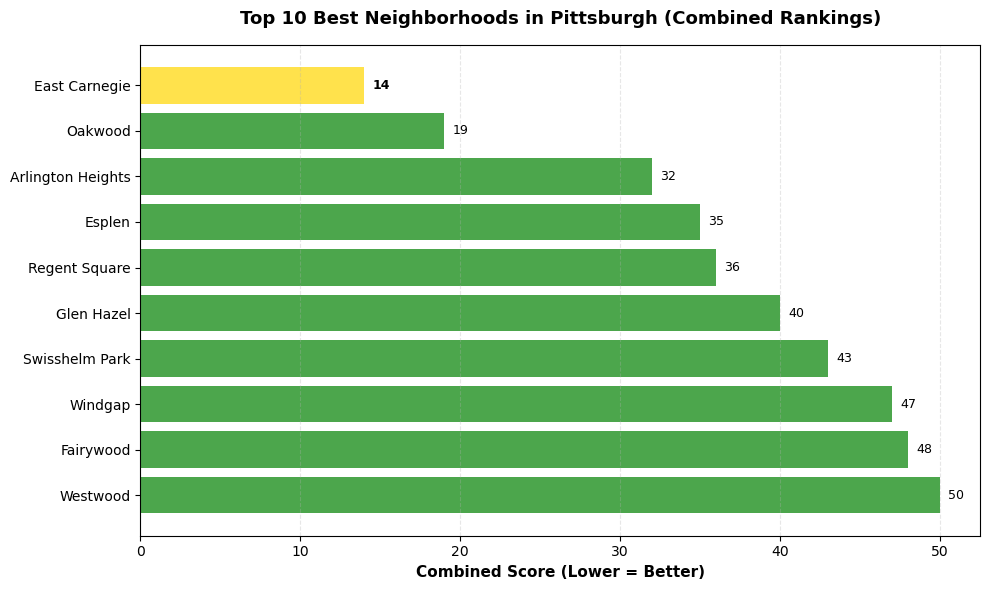

In [17]:
top_10 = combined.head(10)
top_10_names = top_10['neighborhood'].tolist()
top_10_scores = top_10['combined_score'].tolist()
colors_plot = ['gold' if i == 0 else 'green' for i in range(len(top_10))]

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(top_10)), top_10_scores, color=colors_plot, alpha=0.7)
plt.yticks(range(len(top_10)), top_10_names, fontsize=10)
plt.xlabel('Combined Score (Lower = Better)', fontweight='bold', fontsize=11)
plt.title('Top 10 Best Neighborhoods in Pittsburgh (Combined Rankings)', 
          fontsize=13, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, score in enumerate(top_10_scores):
    plt.text(score + max(top_10_scores) * 0.01, i, f"{score:.0f}", 
             va='center', fontsize=9, fontweight='bold' if i == 0 else 'normal')

plt.tight_layout()
plt.show()


### Visualization 2: Ranking Breakdown by Metric

This grouped bar chart shows how each of the top 10 neighborhoods ranks across the three individual metrics. This allows us to see which neighborhoods excel in specific areas and which provide the most balanced safety profile across all dimensions.


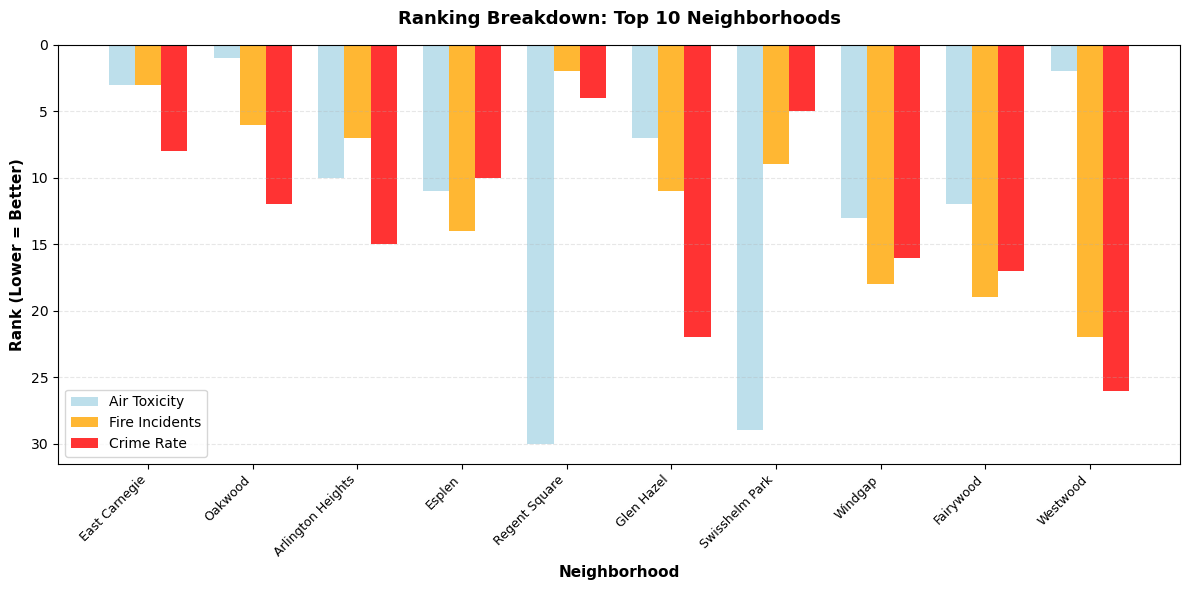

In [18]:
top_10 = combined.head(10)

plt.figure(figsize=(12, 6))
x = np.arange(len(top_10))
width = 0.25

plt.bar(x - width, top_10['air_rank'], width, label='Air Toxicity', color='lightblue', alpha=0.8)
plt.bar(x, top_10['fire_rank'], width, label='Fire Incidents', color='orange', alpha=0.8)
plt.bar(x + width, top_10['crime_rank'], width, label='Crime Rate', color='red', alpha=0.8)

plt.xlabel('Neighborhood', fontweight='bold', fontsize=11)
plt.ylabel('Rank (Lower = Better)', fontweight='bold', fontsize=11)
plt.title('Ranking Breakdown: Top 10 Neighborhoods', fontsize=13, fontweight='bold', pad=15)
plt.xticks(x, top_10['neighborhood'], rotation=45, ha='right', fontsize=9)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


### Why East Carnegie is the Best

East Carnegie achieved the best combined score of **14.0** because it consistently ranks well across all three safety dimensions, demonstrating exceptional balance:

- **Air Quality Rank: 3rd**: This neighborhood has minimal toxic air releases, making it one of the healthiest places to breathe in Pittsburgh. Residents can enjoy clean air without worrying about long-term health impacts from environmental pollution.

- **Fire Safety Rank: 3rd**: With relatively few fire incidents, residents can feel secure about their property and community infrastructure. This suggests well-maintained buildings, effective fire prevention, and reliable emergency services.

- **Crime Rate Rank: 8th**: The low crime rate means residents can walk the streets safely and trust in their community's security. The focus on serious crimes (assaults, robberies, burglaries) ensures we're measuring true safety concerns.

What makes East Carnegie stand out is not just that it ranks well in individual categories, but that it achieves **consistency across all three metrics**. While other neighborhoods might excel in one area (like Oakwood ranking 1st in air quality or Regent Square ranking 2nd in fire incidents), East Carnegie's balanced performance across all dimensions makes it the most reliable choice for overall safety.

This neighborhood represents the optimal balance of environmental health, infrastructure safety, and community security, making it the best overall choice for Pittsburgh residents seeking a safe, healthy place to live. The data clearly shows that when it comes to comprehensive safety, East Carnegie leads the way.



## Conclusion

Each team member reflects on how the data-driven determination of "best neighborhood" compares to their personal favorite neighborhood:

### Riya Shah

If I had to choose based on personal preference, I would likely pick a neighborhood like Squirrel Hill or Shadyside which are known for their walkability, restaurants, and cultural amenities.

This difference highlights a distinction between what the data tells us about safety and what makes a neighborhood personally appealing. While East Carnegie excels in air quality, fire safety, and low crime rates, my personal preferences are influenced by factors that weren't measured in this analysis, like social factors and quality of life.

However, this analysis has made me reconsider what "best" means. Safety is fundamental, since you can't fully enjoy a neighborhood's amenities if you're concerned about air quality, crime, or fire risks. The data-driven approach provides an objective foundation for decision-making, but personal preferences will always play a role. Ideally, someone would find a neighborhood that balances both: strong safety metrics AND also the lifestyle factors that matter most to them.


### Akansh Karody

My personal favorite neighborhood in Pittsburgh is the strip district. I’m not from around the Pittsburgh area so I haven’t been able to become familiar with a lot of the neighborhoods and towns, but the strip district was a cool place to see. What I really liked about it was just being able to walk around with my friends and see a bunch of different stores. It may not be the safest or best place to be when it comes to using our metrics, but in terms of a place to hangout with friends, it was a great place to go to. In my future at Pitt, I hope to continue to go to strip district, and see all the different stores and places that they have to offer, while also exploring other areas, and neighborhoods, to see what other places I like.
Based on the data from all three of the datasets, East Carnegie is the best neighborhood to live in. Our metric took into account the safety of a resident in this town, which may be different from a town that is the most enjoyable to live in. Some other factors that could be taken into account are things like how good the school system is, or how nice the local center is. There are many different factors that can affect what actually is the best neighborhood in Pittsburgh. But when it comes to deciding what neighborhood to stay in, safety is one of the most important aspects to consider.

### Connor Seto

Based on the data from the City of Pittsburgh datasets, East Carnegie emerged as the best neighborhood in terms of safety. It reported the fewest fire incidents, suggesting that it is a quieter, low-risk area with well-maintained infrastructure and lower population density, all of which contribute to fewer unsafe environments. From a data perspective, this makes East Carnegie one of the safest neighborhoods in Pittsburgh. However, my personal favorite neighborhood is **Squirrel Hill**. While it may not have the lowest number of incidents, it stands out for its strong sense of community, walkable streets, local businesses, and cultural diversity. Squirrel Hill offers access to parks, good schools, and a mix of residential and commercial areas that make it vibrant and welcoming. Together, these findings show that while data can help identify safety and risk factors, personal preference often involves a broader picture including community atmosphere and quality of life that numbers alone can’t fully capture.